# Strategic Asset Allocation

---

## Markowitz' Mean-Variance Analysis for Portfolio Optimisation and the Efficient Frontier

### Step 1: Data Collection and Cleaning

To get started, we build datasets of daily close prices for each stock currently listed on the NASDAQ and the NYSE using pandas dataframes. Each set comprises all 11 sectors grouped by market cap.

In [5]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 16.4 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-

In [6]:
# Import dependencies
import ast
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import re
import requests
import time

import concurrent.futures as cf
import yfinance as yf

We should test our code and debug before scraping lots of data first. Let's see how things work with the large-cap `.csv` files.

In [7]:
# Load the dataset
lcND = pd.read_csv('https://raw.githubusercontent.com/JasonBenichou/indeng243/main/Tickers/RawData/Large_All_NSDQ.csv')
lcNE = pd.read_csv('https://raw.githubusercontent.com/JasonBenichou/indeng243/main/Tickers/RawData/Large_All_NYSE.csv')

lc_df = pd.concat([lcND,lcNE], axis=0)
lc_df.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAL,American Airlines Group Inc. Common Stock,$15.88,-0.71,-4.28%,1.033220e+10,United States,NaN,18461935,Consumer Discretionary,Air Freight/Delivery Services
1,AAPL,Apple Inc. Common Stock,$150.59,-2.28,-1.491%,2.610830e+12,United States,1980.0,53749146,Technology,Computer Manufacturing
2,ABNB,Airbnb Inc. Class A Common Stock,$119.84,-5.16,-4.128%,7.147246e+10,United States,2020.0,6133771,Consumer Discretionary,Hotels/Resorts
3,ADBE,Adobe Inc. Common Stock,$338.37,-7.47,-2.16%,1.549058e+11,United States,1986.0,3797381,Technology,Computer Software: Prepackaged Software
4,ADI,Analog Devices Inc. Common Stock,$183.56,-3.01,-1.613%,9.285428e+10,United States,NaN,3627260,Technology,Semiconductors


In [8]:
# Drop duplicates w/ pandas method
lc_dupStocks = lc_df.drop_duplicates(inplace=True)
print(lc_dupStocks)

None


In [9]:
# Create a list of all the ticker symbols for large-caps
lc_tickers = [symbol for symbol in lc_df['Symbol']]
len(lc_tickers)

531

Now, we are ready to retrieve financial data from Yahoo Finance, but we are I/O limited in calling this API. The mulithreading function below will allow us to pass in data and ensure we only use the number of threads available by the CPU. (The value depends on how many threads per core your computer can handle.)

In [10]:
# Define function to call Yahoo API and retrieve the financial data
temp_list = []
def collect_data(ticker):
    try:
        for symbol in ticker:
            data = yf.download(symbol, start='2012-01-01', end='2023-03-01', group_by='Ticker')
            data['Ticker'] = symbol
            temp_list.append(data)

    except:
        print('Error during stock data collection')

In [11]:
# Run multithreading operation for large-caps
start = time.time()
executor = cf.ThreadPoolExecutor(16)
futures = [executor.submit(collect_data(lc_tickers))]  # pass the lc_tickers
cf.wait(futures)
end = time.time()
print('  time taken {:.2f} s'.format(end-start))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [12]:
# Later we will clear the temp_list variable for new downloads
# Assign the current data to a new variable for future use
lc_temp = temp_list

In [13]:
# Check the no. of observations
len(lc_temp)

531

---

* **Large-Cap Daily Close Prices**

In [14]:
# Keep the close price for each ticker by date
lc_close = pd.concat(lc_temp).pivot(columns='Ticker', values='Close')
lc_close.index = pd.to_datetime(lc_close.index)
lc_close.head()

Ticker,A,AAL,AAPL,ABBV,ABC,ABNB,ABT,ACI,ACM,ADBE,...,XM,XOM,XYL,YUM,YUMC,ZBH,ZBRA,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,26.094421,5.12,14.686786,NaN,38.070000,NaN,27.214256,NaN,20.799999,28.570000,...,NaN,86.000000,25.139999,42.106400,NaN,52.368931,35.720001,NaN,NaN,NaN
2012-01-04,25.886980,5.03,14.765714,NaN,38.200001,NaN,27.108700,NaN,20.840000,28.280001,...,NaN,86.019997,25.969999,42.393963,NaN,51.660194,35.450001,NaN,NaN,NaN
2012-01-05,26.466381,5.47,14.929643,NaN,38.490002,NaN,27.046326,NaN,21.070000,28.480000,...,NaN,85.760002,25.600000,42.717468,NaN,52.271847,35.400002,NaN,NaN,NaN
2012-01-06,26.752504,5.60,15.085714,NaN,38.590000,NaN,26.801628,NaN,21.190001,28.719999,...,NaN,85.120003,25.170000,43.026600,NaN,52.407768,35.110001,NaN,NaN,NaN
2012-01-09,27.453505,5.72,15.061786,NaN,38.570000,NaN,26.796829,NaN,21.240000,28.530001,...,NaN,85.500000,25.270000,42.861252,NaN,52.796116,34.950001,NaN,NaN,NaN


In [15]:
# Find the first valid observation in a column & return its index
# first_valid_index = lc_close.apply(lambda x: x.first_valid_index())
# first_valid_index

In [16]:
# List the ticker & total NaN values in the data
lc_null = pd.DataFrame()
lc_null['NaN'] = lc_close.isnull().sum()
lc_null = lc_null.loc[lc_null['NaN'] != 0]
lc_null.reset_index(inplace=True)
lc_null

,Ticker,NaN
0,ABBV,250
1,ABNB,2250
2,ACI,2134
3,AGR,996
4,BJ,1632
...,...,...
75,XM,2282
76,YUMC,1205
77,ZM,1834
78,ZS,1560


Since 2012, several companies in our set were not listed for the entire period. Since our dataset consists of large-cap stocks, we can remove the names from our selection that weren't listed during all years by recalling some underlying theory of this market cap which suggests large-caps represent stability. We assume that stability can be represented by maintaining large-cap status over the past 10 years, and we don't consider corporate actions that may have caused ticker symbol changes through mergers or otherwise; if values are present for all years in the set, the company is removed from our selection. The new dataframe created after removing such entries provides daily close prices on 451 US domestic companies with a market cap greater than or equal to \$10B currently listed since at least 01-01-2012.

In [17]:
# Build df of close prices after dropping tickers w/ NaN values
large_close = lc_close.loc[:,lc_close.notna().all(axis=0)]
large_close

Ticker,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,WST,WTRG,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,26.094421,5.12,14.686786,38.070000,27.214256,20.799999,28.570000,36.029999,47.813873,30.809999,...,19.075001,17.448000,19.100000,113.970001,27.340000,86.000000,25.139999,42.106400,52.368931,35.720001
2012-01-04,25.886980,5.03,14.765714,38.200001,27.108700,20.840000,28.280001,35.980000,47.761192,30.209999,...,18.895000,17.304001,18.889999,112.010002,27.160000,86.019997,25.969999,42.393963,51.660194,35.450001
2012-01-05,26.466381,5.47,14.929643,38.490002,27.046326,21.070000,28.480000,36.139999,48.112377,30.820000,...,18.915001,17.208000,18.780001,110.839996,27.280001,85.760002,25.600000,42.717468,52.271847,35.400002
2012-01-06,26.752504,5.60,15.085714,38.590000,26.801628,21.190001,28.719999,35.900002,48.182617,30.959999,...,18.975000,17.160000,19.020000,106.940002,27.200001,85.120003,25.170000,43.026600,52.407768,35.110001
2012-01-09,27.453505,5.72,15.061786,38.570000,26.796829,21.240000,28.530001,36.599998,47.998245,31.080000,...,19.014999,17.000000,18.790001,106.639999,27.219999,85.500000,25.270000,42.861252,52.796116,34.950001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,142.080002,15.56,148.910004,160.130005,102.690002,88.150002,348.720001,183.759995,222.929993,216.699997,...,305.549988,45.369999,30.840000,107.669998,66.690002,109.730003,103.019997,129.309998,123.620003,304.869995
2023-02-23,143.199997,15.87,149.399994,159.500000,102.550003,88.070000,347.019989,185.649994,222.779999,221.160004,...,312.029999,45.139999,31.059999,105.839996,66.330002,110.739998,103.309998,128.669998,123.169998,301.000000
2023-02-24,141.199997,15.56,146.710007,158.570007,100.459999,87.139999,320.540009,182.940002,221.580002,192.529999,...,310.250000,44.400002,30.870001,105.529999,65.809998,110.750000,102.400002,126.830002,122.699997,291.920013


In [18]:
# Derive the trading days in a year from the large-cap data
lc_trDays_year = pd.DataFrame(large_close['A'].groupby([large_close['A'].index.year]).agg('count')).reset_index()
lc_trDays_year.rename(columns={'A': 'Trading Days'}, inplace=True)
lc_trDays_year

,Date,Trading Days
0,2012,250
1,2013,252
2,2014,252
3,2015,252
4,2016,252
5,2017,251
6,2018,251
7,2019,252
8,2020,253
9,2021,252


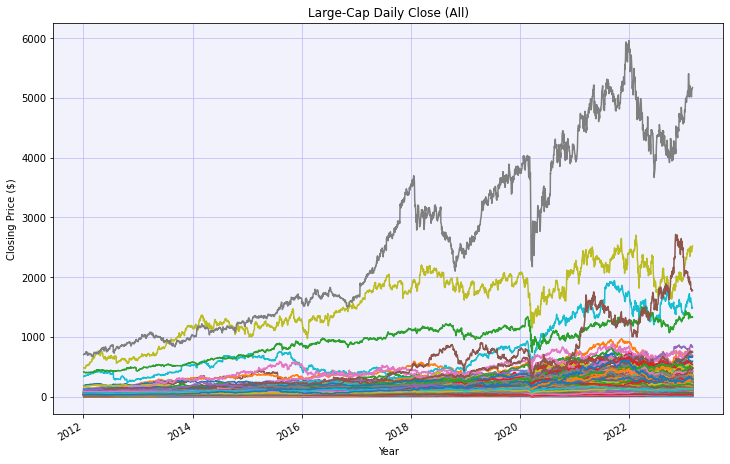

In [19]:
# Visualise the large-cap data
fig, ax = plt.subplots(figsize=(12,8))
large_close.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Large-Cap Daily Close (All)')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

The code works like we want it to, so let's finish collecting the data for mid- and small-caps.

---

* **Mid-cap Daily Close Prices**

In [20]:
# Mid-Caps
mcND = pd.read_csv('https://raw.githubusercontent.com/JasonBenichou/indeng243/main/Tickers/RawData/Mid_All_NSDQ.csv')
mcNE = pd.read_csv('https://raw.githubusercontent.com/JasonBenichou/indeng243/main/Tickers/RawData/Mid_All_NYSE.csv')
mc_df = pd.concat([mcNE,mcND], axis=0)

In [21]:
# Drop duplicates w/ pandas method if exist
mc_dup_stocks = mc_df.drop_duplicates(inplace=True)
print(mc_dup_stocks)

None


In [22]:
# Create a list of all the ticker symbols for mid-caps
mc_tickers = [symbol for symbol in mc_df['Symbol']]

# Print the no. of entries in the list
print(len(mc_tickers))

782


In [23]:
# Run multithreading operation for mid-caps
del temp_list  # clear the temp_list variable
temp_list = []  # initiate the temp variable

start = time.time()
executor = cf.ThreadPoolExecutor(16)
futures = [executor.submit(collect_data(mc_tickers))]  # pass the mc_tickers
cf.wait(futures)
end = time.time()
print('  time taken {:.2f} s'.format(end-start))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [24]:
# Assign the current data to a new variable for future use
mc_temp = temp_list

In [25]:
# Check the no. of observations
len(mc_temp)

782

In [26]:
# Keep the close price for each mid-cap ticker by date
mc_close = pd.concat(mc_temp).pivot(columns='Ticker', values='Close')
mc_close.index = pd.to_datetime(mc_close.index)
mc_close.head()

Ticker,AAON,AAP,AAWW,AB,ABCB,ABG,ABM,ABR,ACAD,ACHC,...,XRAY,XRX,YELP,YETI,Z,ZD,ZG,ZI,ZION,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,9.160000,69.099998,38.880001,13.45,10.57,21.709999,20.879999,3.53,1.11,9.92,...,35.380001,21.607378,NaN,NaN,NaN,25.078260,7.193639,NaN,16.770000,NaN
2012-01-04,9.084444,70.720001,39.279999,14.10,10.36,21.500000,20.620001,3.48,1.09,9.74,...,35.369999,21.475626,NaN,NaN,NaN,24.573914,7.174930,NaN,17.139999,NaN
2012-01-05,9.031111,71.169998,38.700001,14.80,10.42,21.660000,20.219999,3.49,1.10,9.77,...,35.400002,21.343874,NaN,NaN,NaN,25.060869,7.171812,NaN,17.620001,NaN
2012-01-06,8.933333,71.500000,39.020000,14.88,10.64,21.570000,20.360001,3.60,1.15,11.36,...,35.189999,21.343874,NaN,NaN,NaN,24.765217,7.184284,NaN,17.639999,NaN
2012-01-09,8.911111,71.480003,39.900002,14.81,10.62,22.389999,20.320000,3.72,1.19,11.30,...,35.020000,21.317522,NaN,NaN,NaN,24.330435,7.181166,NaN,17.879999,NaN


In [27]:
# List the ticker & total NaN values in the data
mc_null = pd.DataFrame()
mc_null['NaN'] = mc_close.isnull().sum()
mc_null = mc_null.loc[mc_null['NaN'] != 0]
mc_null.reset_index(inplace=True)
mc_null

,Ticker,NaN
0,ACT,2442
1,ADT,1521
2,AFRM,2272
3,AKRO,1877
4,ALGM,2221
...,...,...
260,YELP,41
261,YETI,1715
262,Z,900
263,ZI,2118


In [28]:
# Build df of mid-cap close prices after dropping tickers w/ NaN values
mid_close = mc_close.loc[:,mc_close.notna().all(axis=0)]
mid_close

Ticker,AAON,AAP,AAWW,AB,ABCB,ABG,ABM,ABR,ACAD,ACHC,...,WU,WWD,WWE,X,XPO,XRAY,XRX,ZD,ZG,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,9.160000,69.099998,38.880001,13.450000,10.570000,21.709999,20.879999,3.53,1.110000,9.920000,...,18.549999,41.980000,9.460000,28.170000,4.094911,35.380001,21.607378,25.078260,7.193639,16.770000
2012-01-04,9.084444,70.720001,39.279999,14.100000,10.360000,21.500000,20.620001,3.48,1.090000,9.740000,...,18.299999,42.250000,9.340000,28.440001,4.053408,35.369999,21.475626,24.573914,7.174930,17.139999
2012-01-05,9.031111,71.169998,38.700001,14.800000,10.420000,21.660000,20.219999,3.49,1.100000,9.770000,...,18.389999,42.650002,9.500000,27.790001,4.056867,35.400002,21.343874,25.060869,7.171812,17.620001
2012-01-06,8.933333,71.500000,39.020000,14.880000,10.640000,21.570000,20.360001,3.60,1.150000,11.360000,...,18.309999,42.580002,9.640000,27.299999,4.091452,35.189999,21.343874,24.765217,7.184284,17.639999
2012-01-09,8.911111,71.480003,39.900002,14.810000,10.620000,22.389999,20.320000,3.72,1.190000,11.300000,...,18.370001,43.119999,9.530000,26.780001,4.046491,35.020000,21.317522,24.330435,7.181166,17.879999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,78.029999,143.619995,101.820000,38.770000,47.220001,228.979996,48.200001,15.29,18.959999,80.669998,...,13.450000,99.639999,85.070000,28.389999,34.630001,35.139999,16.250000,82.150002,41.740002,49.320000
2023-02-23,80.370003,142.009995,101.779999,39.529999,48.290001,229.389999,48.790001,15.36,19.100000,80.489998,...,13.270000,98.029999,86.519997,28.309999,34.689999,35.220001,16.610001,81.599998,41.570000,49.360001
2023-02-24,81.470001,138.850006,101.750000,39.230000,48.020000,221.240005,48.820000,15.28,18.920000,80.250000,...,13.090000,97.919998,85.790001,28.270000,34.169998,34.330002,16.280001,79.769997,40.500000,50.270000


In [29]:
# Derive the trading days in a year from the mid-cap data
mc_trDays_year = pd.DataFrame(mid_close['AAON'].groupby([mid_close['AAON'].index.year]).agg('count')).reset_index()
mc_trDays_year.rename(columns={'AAON': 'Trading Days'}, inplace=True)
mc_trDays_year

,Date,Trading Days
0,2012,250
1,2013,252
2,2014,252
3,2015,252
4,2016,252
5,2017,251
6,2018,251
7,2019,252
8,2020,253
9,2021,252


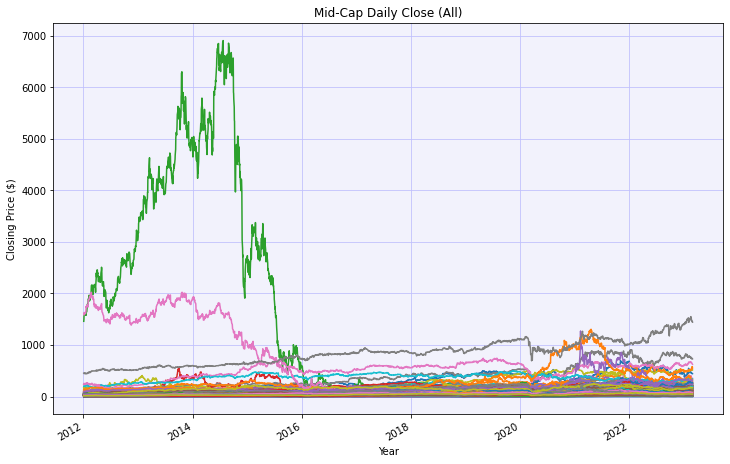

In [30]:
# Visualise the mid-cap data
fig, ax = plt.subplots(figsize=(12,8))
mid_close.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Mid-Cap Daily Close (All)')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

---

* **Small-cap Daily Close Prices**

In [31]:
# Small-Caps
scND = pd.read_csv('https://raw.githubusercontent.com/JasonBenichou/indeng243/main/Tickers/RawData/Small_All_NSDQ.csv')
scNE = pd.read_csv('https://raw.githubusercontent.com/JasonBenichou/indeng243/main/Tickers/RawData/Small_All_NYSE.csv')
sc_df = pd.concat([scNE,scND], axis=0)

In [32]:
# Drop duplicates w/ pandas method if exist
sc_dup_stocks = sc_df.drop_duplicates(inplace=True)
print(sc_dup_stocks)

None


In [33]:
# Create a list of all the ticker symbols for small-caps
sc_tickers = [symbol for symbol in sc_df['Symbol']]

# Print the no. of entries in the list
print(len(sc_tickers))

3727


In [34]:
# Run multithreading operation for small-caps
del temp_list  # clear the temp_list variable
temp_list = []  # initiate the temp variable

start = time.time()
executor = cf.ThreadPoolExecutor(16)
futures = [executor.submit(collect_data(sc_tickers))]  # pass the sc_tickers
cf.wait(futures)
end = time.time()
print('  time taken {:.2f} s'.format(end-start))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [35]:
# Assign the current data to a new variable for future use
sc_temp = temp_list

In [36]:
# Check the no. of observations
len(sc_temp)

1011

In [37]:
# Keep the close price for each small-cap ticker by date
sc_close = pd.concat(sc_temp).pivot(columns='Ticker', values='Close')
sc_close.index = pd.to_datetime(sc_close.index)
sc_close.head()

Ticker,AACI,AADI,AAIC,AAIN,AAME,AAOI,AAT,ABEO,ABIO,ABOS,...,WOW,WSR,WT,WTI,WTTR,WWW,XFLT,XHR,YEXT,ZTR
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,NaN,21.420000,NaN,1.97,NaN,20.920000,1750.0,756.000000,NaN,...,NaN,12.31,6.02,22.320000,NaN,17.180000,NaN,NaN,NaN,12.28
2012-01-04,NaN,NaN,20.799999,NaN,1.96,NaN,20.250000,1750.0,748.440002,NaN,...,NaN,12.23,6.07,21.719999,NaN,17.200001,NaN,NaN,NaN,12.24
2012-01-05,NaN,NaN,21.020000,NaN,2.03,NaN,20.490000,1750.0,740.880005,NaN,...,NaN,12.30,6.10,21.490000,NaN,17.459999,NaN,NaN,NaN,12.16
2012-01-06,NaN,NaN,20.680000,NaN,1.98,NaN,20.370001,1700.0,771.119995,NaN,...,NaN,12.31,6.07,21.030001,NaN,17.254999,NaN,NaN,NaN,12.20
2012-01-09,NaN,NaN,20.590000,NaN,2.02,NaN,19.920000,1700.0,763.559998,NaN,...,NaN,12.38,6.14,21.170000,NaN,17.490000,NaN,NaN,NaN,12.20


In [38]:
# List the ticker & total NaN values in the small-cap data
sc_null = pd.DataFrame()
sc_null['NaN'] = sc_close.isnull().sum()
sc_null = sc_null.loc[sc_null['NaN'] != 0]
sc_null.reset_index(inplace=True)
sc_null

,Ticker,NaN
0,AACI,2481
1,AADI,1541
2,AAIN,2400
3,AAOI,435
4,ABOS,2389
...,...,...
372,WOW,1357
373,WTTR,1378
374,XFLT,1451
375,XHR,776


In [39]:
# Build df of small-cap close prices after dropping tickers w/ NaN values
small_close = sc_close.loc[:,sc_close.notna().all(axis=0)]
small_close

Ticker,AAIC,AAME,AAT,ABEO,ABIO,ABVC,ACCO,ACER,ACGN,ACHV,...,WHG,WIA,WIW,WLY,WNC,WSR,WT,WTI,WWW,ZTR
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.420000,1.97,20.920000,1750.00,756.000000,2579.617920,9.77,316.666656,157.759995,26158.00,...,37.230000,12.70,12.71,45.139999,8.01,12.31,6.02,22.320000,17.180000,12.28
2012-01-04,20.799999,1.96,20.250000,1750.00,748.440002,2579.617920,9.66,313.333344,157.759995,25784.00,...,36.540001,12.68,12.80,44.200001,8.10,12.23,6.07,21.719999,17.200001,12.24
2012-01-05,21.020000,2.03,20.490000,1750.00,740.880005,3582.802490,9.36,316.666656,152.320007,25388.00,...,37.020000,12.67,12.78,44.980000,8.60,12.30,6.10,21.490000,17.459999,12.16
2012-01-06,20.680000,1.98,20.370001,1700.00,771.119995,3582.802490,9.33,316.666656,152.320007,25960.00,...,36.770000,12.65,12.72,45.310001,8.70,12.31,6.07,21.030001,17.254999,12.20
2012-01-09,20.590000,2.02,19.920000,1700.00,763.559998,2063.694336,9.34,306.666656,160.479996,27192.00,...,36.840000,12.66,12.73,44.529999,8.90,12.38,6.14,21.170000,17.490000,12.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,3.020000,2.40,25.740000,2.33,2.120000,0.750000,5.59,2.180000,4.850000,5.22,...,11.600000,8.55,9.07,44.200001,27.40,9.80,6.08,5.300000,15.990000,6.51
2023-02-23,3.040000,2.38,25.809999,2.30,2.100000,0.730000,5.67,2.160000,5.020000,5.07,...,12.340000,8.60,9.12,44.619999,26.90,9.85,6.07,5.530000,16.910000,6.55
2023-02-24,3.030000,2.40,25.469999,2.25,2.090000,0.695000,5.39,2.140000,4.510000,4.99,...,12.000000,8.52,9.09,44.849998,26.26,9.48,6.08,5.630000,16.059999,6.55


In [40]:
# Derive the trading days in a year from the mid-cap data
sc_trDays_year = pd.DataFrame(small_close['AAIC'].groupby([small_close['AAIC'].index.year]).agg('count')).reset_index()
sc_trDays_year.rename(columns={'AAIC': 'Trading Days'}, inplace=True)
sc_trDays_year

,Date,Trading Days
0,2012,250
1,2013,252
2,2014,252
3,2015,252
4,2016,252
5,2017,251
6,2018,251
7,2019,252
8,2020,253
9,2021,252


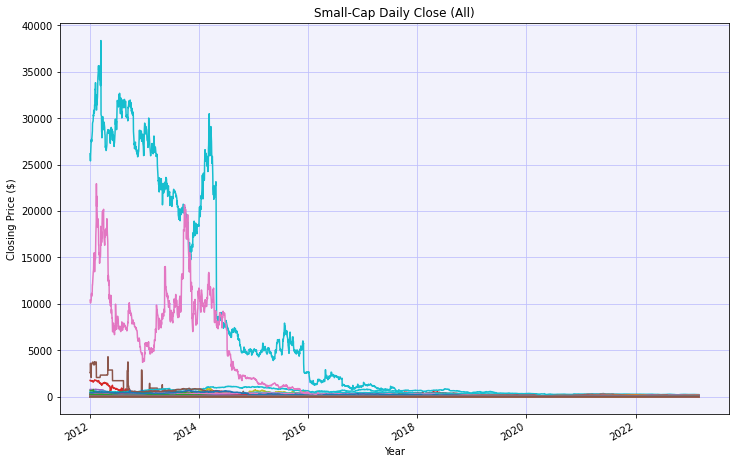

In [41]:
# Visualise the small-cap data
fig, ax = plt.subplots(figsize=(12,8))
small_close.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Small-Cap Daily Close (All)')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

One caveat to using data from Yahoo or other public APIs is the quality of financial data we seek. After observing the plots of each market cap, it's not immediately clear if closing prices reflect stock splits or not. Despite a comment found in QuantStackExchange mentioning that Yahoo's historical close prices are backwards adjusted for corporate actions, even if this is true in some way we don't know if the adjustments are splits only or including dividends. Fortunately we saved the raw data in some temp variables that we can use to go back and extract the adjusted close prices. Let's check what the large-cap set returns when we run our code for the adjusted attribute. This will help us decide which prices to use for our technical analysis and backtesting. For buy and hold strategies, one argument is to use split-adjusted data including dividend payments since these actions would affect performance when holding the stock for longer periods. On the other hand, for a short-term trading system, stops and exits based on dollar values are not appropriate for split-adjusted data

---

#### Adjusted Close Pricing

* **Large-Cap Daily Adjusted Close Prices**

In [42]:
# Keep the adjusted close price for each ticker by date
lc_adjClose = pd.concat(lc_temp).pivot(columns='Ticker', values='Adj Close')
lc_adjClose.index = pd.to_datetime(lc_adjClose.index)
lc_adjClose.head()

Ticker,A,AAL,AAPL,ABBV,ABC,ABNB,ABT,ACI,ACM,ADBE,...,XM,XOM,XYL,YUM,YUMC,ZBH,ZBRA,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.661139,4.826836,12.500193,NaN,31.948917,NaN,21.708197,NaN,20.583385,28.570000,...,NaN,54.496990,21.578623,33.970028,NaN,47.716305,35.720001,NaN,NaN,NaN
2012-01-04,23.473030,4.741990,12.567369,NaN,32.058006,NaN,21.623999,NaN,20.622972,28.280001,...,NaN,54.509655,22.291040,34.202026,NaN,47.070526,35.450001,NaN,NaN,NaN
2012-01-05,23.998407,5.156796,12.706891,NaN,32.301399,NaN,21.574238,NaN,20.850576,28.480000,...,NaN,54.344921,21.973455,34.463028,NaN,47.627831,35.400002,NaN,NaN,NaN
2012-01-06,24.257854,5.279351,12.839729,NaN,32.385303,NaN,21.379051,NaN,20.969326,28.719999,...,NaN,53.939365,21.604372,34.712425,NaN,47.751690,35.110001,NaN,NaN,NaN
2012-01-09,24.893488,5.392482,12.819362,NaN,32.368519,NaN,21.375219,NaN,21.018805,28.530001,...,NaN,54.180130,21.690207,34.579021,NaN,48.105518,34.950001,NaN,NaN,NaN


In [43]:
# List the ticker & total NaN values in the data
lc_adj_null = pd.DataFrame()
lc_adj_null['NaN'] = lc_adjClose.isnull().sum()
lc_adj_null = lc_adj_null.loc[lc_adj_null['NaN'] != 0]
lc_adj_null.reset_index(inplace=True)
lc_adj_null

,Ticker,NaN
0,ABBV,250
1,ABNB,2250
2,ACI,2134
3,AGR,996
4,BJ,1632
...,...,...
75,XM,2282
76,YUMC,1205
77,ZM,1834
78,ZS,1560


In [44]:
# Build df of close prices after dropping tickers w/ NaN values
large_adjClose = lc_adjClose.loc[:,lc_adjClose.notna().all(axis=0)]
large_adjClose

Ticker,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,WST,WTRG,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.661139,4.826836,12.500193,31.948917,21.708197,20.583385,28.570000,27.605873,36.966000,30.809999,...,17.661880,13.303111,12.364989,85.516479,19.092758,54.496990,21.578623,33.970028,47.716305,35.720001
2012-01-04,23.473030,4.741990,12.567369,32.058006,21.623999,20.622972,28.280001,27.567585,36.925274,30.209999,...,17.495216,13.193316,12.229045,84.045815,18.967060,54.509655,22.291040,34.202026,47.070526,35.450001
2012-01-05,23.998407,5.156796,12.706891,32.301399,21.574238,20.850576,28.480000,27.690163,37.196789,30.820000,...,17.513742,13.120120,12.157833,83.167885,19.050858,54.344921,21.973455,34.463028,47.627831,35.400002
2012-01-06,24.257854,5.279351,12.839729,32.385303,21.379051,20.969326,28.719999,27.506275,37.251087,30.959999,...,17.569290,13.083527,12.313201,80.241608,18.994987,53.939365,21.604372,34.712425,47.751690,35.110001
2012-01-09,24.893488,5.392482,12.819362,32.368519,21.375219,21.018805,28.530001,28.042620,37.108543,31.080000,...,17.606325,12.961535,12.164308,80.016457,19.008959,54.180130,21.690207,34.579021,48.105518,34.950001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,142.080002,15.560000,148.910004,160.130005,102.690002,88.150002,348.720001,182.908752,221.674591,216.699997,...,305.549988,45.369999,30.655039,107.669998,66.690002,109.730003,103.019997,129.309998,123.620003,304.869995
2023-02-23,143.199997,15.870000,149.399994,159.500000,102.550003,88.070000,347.019989,184.789993,221.525436,221.160004,...,312.029999,45.139999,30.873718,105.839996,66.330002,110.739998,103.309998,128.669998,123.169998,301.000000
2023-02-24,141.199997,15.560000,146.710007,158.570007,100.459999,87.139999,320.540009,182.940002,220.332199,192.529999,...,310.250000,44.400002,30.684858,105.529999,65.809998,110.750000,102.400002,126.830002,122.699997,291.920013


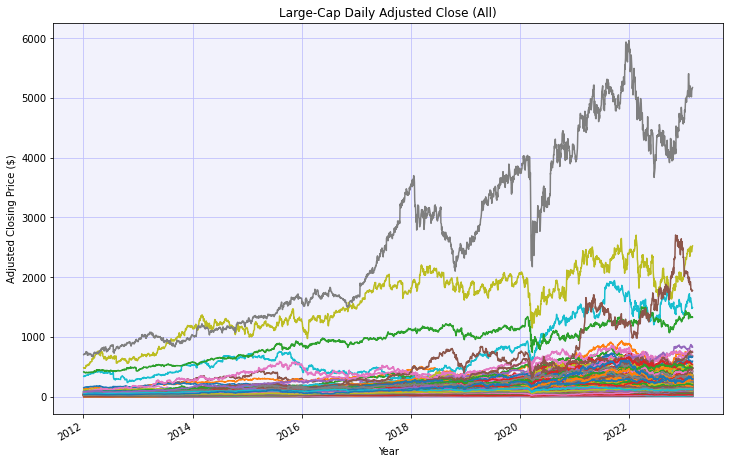

In [45]:
# Visualise the large-cap data
fig, ax = plt.subplots(figsize=(12,8))
large_adjClose.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Large-Cap Daily Adjusted Close (All)')
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

In [46]:
# Export current df to .csv file
large_adjClose.to_csv('Large_Cap_AdjClose.csv', index=True)

---

* **Mid-cap Daily Adjusted Close Prices**

In [47]:
# Keep the adjusted close price for each mid-cap ticker by date
mc_adjClose = pd.concat(mc_temp).pivot(columns='Ticker', values='Close')
mc_adjClose.index = pd.to_datetime(mc_adjClose.index)
mc_adjClose.head()

Ticker,AAON,AAP,AAWW,AB,ABCB,ABG,ABM,ABR,ACAD,ACHC,...,XRAY,XRX,YELP,YETI,Z,ZD,ZG,ZI,ZION,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,9.160000,69.099998,38.880001,13.45,10.57,21.709999,20.879999,3.53,1.11,9.92,...,35.380001,21.607378,NaN,NaN,NaN,25.078260,7.193639,NaN,16.770000,NaN
2012-01-04,9.084444,70.720001,39.279999,14.10,10.36,21.500000,20.620001,3.48,1.09,9.74,...,35.369999,21.475626,NaN,NaN,NaN,24.573914,7.174930,NaN,17.139999,NaN
2012-01-05,9.031111,71.169998,38.700001,14.80,10.42,21.660000,20.219999,3.49,1.10,9.77,...,35.400002,21.343874,NaN,NaN,NaN,25.060869,7.171812,NaN,17.620001,NaN
2012-01-06,8.933333,71.500000,39.020000,14.88,10.64,21.570000,20.360001,3.60,1.15,11.36,...,35.189999,21.343874,NaN,NaN,NaN,24.765217,7.184284,NaN,17.639999,NaN
2012-01-09,8.911111,71.480003,39.900002,14.81,10.62,22.389999,20.320000,3.72,1.19,11.30,...,35.020000,21.317522,NaN,NaN,NaN,24.330435,7.181166,NaN,17.879999,NaN


In [48]:
# List the ticker & total NaN values in the data
mc_adj_null = pd.DataFrame()
mc_adj_null['NaN'] = mc_adjClose.isnull().sum()
mc_adj_null = mc_adj_null.loc[mc_adj_null['NaN'] != 0]
mc_adj_null.reset_index(inplace=True)
mc_adj_null

,Ticker,NaN
0,ACT,2442
1,ADT,1521
2,AFRM,2272
3,AKRO,1877
4,ALGM,2221
...,...,...
260,YELP,41
261,YETI,1715
262,Z,900
263,ZI,2118


In [49]:
# Build df of mid-cap adjusted close prices after dropping tickers w/ NaN values
mid_adjClose = mc_adjClose.loc[:,mc_adjClose.notna().all(axis=0)]
mid_adjClose

Ticker,AAON,AAP,AAWW,AB,ABCB,ABG,ABM,ABR,ACAD,ACHC,...,WU,WWD,WWE,X,XPO,XRAY,XRX,ZD,ZG,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,9.160000,69.099998,38.880001,13.450000,10.570000,21.709999,20.879999,3.53,1.110000,9.920000,...,18.549999,41.980000,9.460000,28.170000,4.094911,35.380001,21.607378,25.078260,7.193639,16.770000
2012-01-04,9.084444,70.720001,39.279999,14.100000,10.360000,21.500000,20.620001,3.48,1.090000,9.740000,...,18.299999,42.250000,9.340000,28.440001,4.053408,35.369999,21.475626,24.573914,7.174930,17.139999
2012-01-05,9.031111,71.169998,38.700001,14.800000,10.420000,21.660000,20.219999,3.49,1.100000,9.770000,...,18.389999,42.650002,9.500000,27.790001,4.056867,35.400002,21.343874,25.060869,7.171812,17.620001
2012-01-06,8.933333,71.500000,39.020000,14.880000,10.640000,21.570000,20.360001,3.60,1.150000,11.360000,...,18.309999,42.580002,9.640000,27.299999,4.091452,35.189999,21.343874,24.765217,7.184284,17.639999
2012-01-09,8.911111,71.480003,39.900002,14.810000,10.620000,22.389999,20.320000,3.72,1.190000,11.300000,...,18.370001,43.119999,9.530000,26.780001,4.046491,35.020000,21.317522,24.330435,7.181166,17.879999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,78.029999,143.619995,101.820000,38.770000,47.220001,228.979996,48.200001,15.29,18.959999,80.669998,...,13.450000,99.639999,85.070000,28.389999,34.630001,35.139999,16.250000,82.150002,41.740002,49.320000
2023-02-23,80.370003,142.009995,101.779999,39.529999,48.290001,229.389999,48.790001,15.36,19.100000,80.489998,...,13.270000,98.029999,86.519997,28.309999,34.689999,35.220001,16.610001,81.599998,41.570000,49.360001
2023-02-24,81.470001,138.850006,101.750000,39.230000,48.020000,221.240005,48.820000,15.28,18.920000,80.250000,...,13.090000,97.919998,85.790001,28.270000,34.169998,34.330002,16.280001,79.769997,40.500000,50.270000


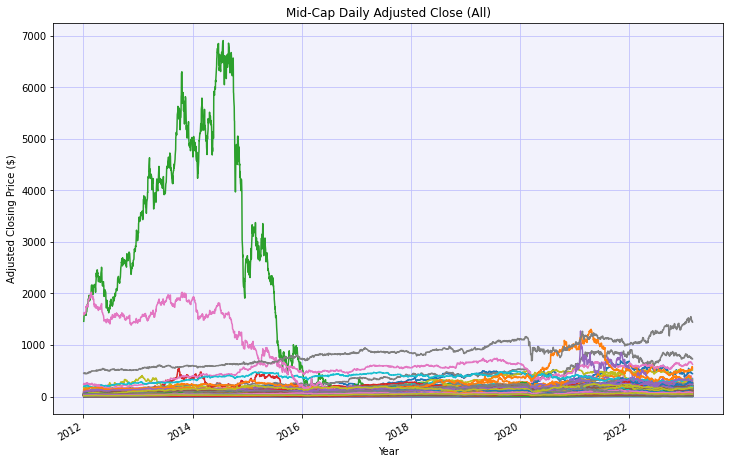

In [50]:
# Visualise the mid-cap data
fig, ax = plt.subplots(figsize=(12,8))
mid_adjClose.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Mid-Cap Daily Adjusted Close (All)')
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

In [51]:
# Export current df to .csv file
mid_adjClose.to_csv('Mid_Cap_AdjClose.csv', index=True)

---

* **Small-cap Daily Adjusted Close Prices**

In [52]:
# Keep the adjusted close price for each small-cap ticker by date
sc_adjClose = pd.concat(sc_temp).pivot(columns='Ticker', values='Close')
sc_adjClose.index = pd.to_datetime(sc_adjClose.index)
sc_adjClose.head()

Ticker,AACI,AADI,AAIC,AAIN,AAME,AAOI,AAT,ABEO,ABIO,ABOS,...,WOW,WSR,WT,WTI,WTTR,WWW,XFLT,XHR,YEXT,ZTR
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,NaN,21.420000,NaN,1.97,NaN,20.920000,1750.0,756.000000,NaN,...,NaN,12.31,6.02,22.320000,NaN,17.180000,NaN,NaN,NaN,12.28
2012-01-04,NaN,NaN,20.799999,NaN,1.96,NaN,20.250000,1750.0,748.440002,NaN,...,NaN,12.23,6.07,21.719999,NaN,17.200001,NaN,NaN,NaN,12.24
2012-01-05,NaN,NaN,21.020000,NaN,2.03,NaN,20.490000,1750.0,740.880005,NaN,...,NaN,12.30,6.10,21.490000,NaN,17.459999,NaN,NaN,NaN,12.16
2012-01-06,NaN,NaN,20.680000,NaN,1.98,NaN,20.370001,1700.0,771.119995,NaN,...,NaN,12.31,6.07,21.030001,NaN,17.254999,NaN,NaN,NaN,12.20
2012-01-09,NaN,NaN,20.590000,NaN,2.02,NaN,19.920000,1700.0,763.559998,NaN,...,NaN,12.38,6.14,21.170000,NaN,17.490000,NaN,NaN,NaN,12.20


In [53]:
# List the ticker & total NaN values in the small-cap data
sc_adj_null = pd.DataFrame()
sc_adj_null['NaN'] = sc_adjClose.isnull().sum()
sc_adj_null = sc_adj_null.loc[sc_adj_null['NaN'] != 0]
sc_adj_null.reset_index(inplace=True)
sc_adj_null

,Ticker,NaN
0,AACI,2481
1,AADI,1541
2,AAIN,2400
3,AAOI,435
4,ABOS,2389
...,...,...
372,WOW,1357
373,WTTR,1378
374,XFLT,1451
375,XHR,776


In [54]:
# Build df of small-cap close prices after dropping tickers w/ NaN values
small_adjClose = sc_adjClose.loc[:,sc_adjClose.notna().all(axis=0)]
small_adjClose

Ticker,AAIC,AAME,AAT,ABEO,ABIO,ABVC,ACCO,ACER,ACGN,ACHV,...,WHG,WIA,WIW,WLY,WNC,WSR,WT,WTI,WWW,ZTR
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.420000,1.97,20.920000,1750.00,756.000000,2579.617920,9.77,316.666656,157.759995,26158.00,...,37.230000,12.70,12.71,45.139999,8.01,12.31,6.02,22.320000,17.180000,12.28
2012-01-04,20.799999,1.96,20.250000,1750.00,748.440002,2579.617920,9.66,313.333344,157.759995,25784.00,...,36.540001,12.68,12.80,44.200001,8.10,12.23,6.07,21.719999,17.200001,12.24
2012-01-05,21.020000,2.03,20.490000,1750.00,740.880005,3582.802490,9.36,316.666656,152.320007,25388.00,...,37.020000,12.67,12.78,44.980000,8.60,12.30,6.10,21.490000,17.459999,12.16
2012-01-06,20.680000,1.98,20.370001,1700.00,771.119995,3582.802490,9.33,316.666656,152.320007,25960.00,...,36.770000,12.65,12.72,45.310001,8.70,12.31,6.07,21.030001,17.254999,12.20
2012-01-09,20.590000,2.02,19.920000,1700.00,763.559998,2063.694336,9.34,306.666656,160.479996,27192.00,...,36.840000,12.66,12.73,44.529999,8.90,12.38,6.14,21.170000,17.490000,12.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,3.020000,2.40,25.740000,2.33,2.120000,0.750000,5.59,2.180000,4.850000,5.22,...,11.600000,8.55,9.07,44.200001,27.40,9.80,6.08,5.300000,15.990000,6.51
2023-02-23,3.040000,2.38,25.809999,2.30,2.100000,0.730000,5.67,2.160000,5.020000,5.07,...,12.340000,8.60,9.12,44.619999,26.90,9.85,6.07,5.530000,16.910000,6.55
2023-02-24,3.030000,2.40,25.469999,2.25,2.090000,0.695000,5.39,2.140000,4.510000,4.99,...,12.000000,8.52,9.09,44.849998,26.26,9.48,6.08,5.630000,16.059999,6.55


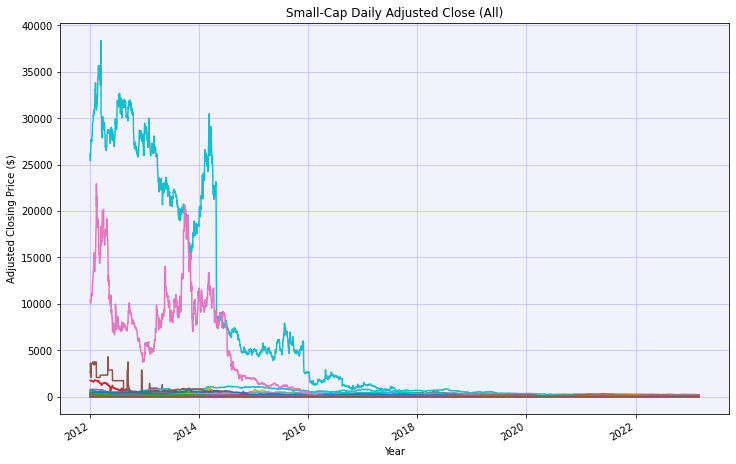

In [55]:
# Visualise the small-cap data
fig, ax = plt.subplots(figsize=(12,8))
small_adjClose.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Small-Cap Daily Adjusted Close (All)')
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

In [56]:
# Export current df to .csv file
small_adjClose.to_csv('Small_Cap_AdjClose.csv', index=True)

In [57]:
# Convert the raw data to single dataframes & save to .csv
lcRaw = pd.concat(lc_temp)
mcRaw = pd.concat(mc_temp)
scRaw = pd.concat(sc_temp)

lcRaw.to_csv('LargeCap_Raw.csv', index=True)
mcRaw.to_csv('MidCap_Raw.csv', index=True)
scRaw.to_csv('SmallCap_Raw.csv', index=True)

---

### Step 2: Statistical Performance Metrics & Analysis

A diversified portfolio should have low correlation between asset classes. Since the portfolios we build will likely be heavily concentrated with stocks, our aim is to ensure low correlation between stocks grouped by market cap.

In [65]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
import pandas as pd
risk_aversion = pd.read_csv("https://raw.githubusercontent.com/JasonBenichou/indeng243/main/Risk_Aversion_Data.csv")
risk = risk_aversion['RiskAversion']
risk

0        5.021125
1        6.658645
2        3.347183
3        3.180899
4        5.075350
           ...   
50395    2.621720
50396    6.021187
50397    4.996553
50398    2.111006
50399    3.180899
Name: RiskAversion, Length: 50400, dtype: float64

#largecap

In [125]:
# Import dependencies
import numpy as np
from pypfopt.expected_returns import mean_historical_return, capm_return
from pypfopt.risk_models import CovarianceShrinkage
import pypfopt as pft

In [164]:
# lmu = mean_historical_return(large_adjClose) # // camp_return
lmu = capm_return(large_adjClose, risk_free_rate=0.0491)
lmu

Ticker
A       0.189671
AAL     0.252707
AAPL    0.185082
ABC     0.151384
ABT     0.160569
          ...   
XOM     0.177975
XYL     0.199647
YUM     0.165369
ZBH     0.178965
ZBRA    0.218817
Name: mkt, Length: 451, dtype: float64

In [216]:
lS = CovarianceShrinkage(large_adjClose).ledoit_wolf()
type(lS)
lS

Ticker,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,WST,WTRG,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.068470,0.040335,0.035272,0.023232,0.033440,0.039109,0.043268,0.041992,0.031044,0.051173,...,0.035826,0.022412,0.037562,0.042559,0.015160,0.024058,0.037507,0.025917,0.030830,0.045428
AAL,0.040335,0.258062,0.039897,0.029387,0.027061,0.058405,0.037708,0.050603,0.040508,0.058135,...,0.019172,0.020762,0.064250,0.097074,0.010533,0.041972,0.050761,0.041123,0.048387,0.052420
AAPL,0.035272,0.039897,0.084635,0.020535,0.028424,0.032184,0.047305,0.044951,0.031112,0.049864,...,0.029917,0.020238,0.037426,0.044296,0.015771,0.022823,0.031907,0.025415,0.027658,0.046616
ABC,0.023232,0.029387,0.020535,0.064642,0.023434,0.029562,0.020478,0.024551,0.025079,0.025806,...,0.019938,0.019525,0.029297,0.024673,0.014629,0.021275,0.023662,0.017803,0.022726,0.024970
ABT,0.033440,0.027061,0.028424,0.023434,0.051936,0.025720,0.033561,0.030349,0.027476,0.035746,...,0.030834,0.022254,0.030572,0.025988,0.017804,0.017381,0.027724,0.021327,0.027356,0.033268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XOM,0.024058,0.041972,0.022823,0.021275,0.017381,0.039603,0.020143,0.030899,0.026809,0.028374,...,0.014029,0.019777,0.039032,0.050232,0.013895,0.067734,0.031229,0.022633,0.028538,0.029790
XYL,0.037507,0.050761,0.031907,0.023662,0.027724,0.047124,0.036414,0.041098,0.033790,0.044963,...,0.027097,0.025588,0.043766,0.048987,0.018288,0.031229,0.072925,0.028835,0.030582,0.042552
YUM,0.025917,0.041123,0.025415,0.017803,0.021327,0.032000,0.028328,0.028844,0.026162,0.033166,...,0.020066,0.021400,0.034751,0.039711,0.015841,0.022633,0.028835,0.061080,0.026873,0.029692


In [128]:
lcorr = pft.risk_models.cov_to_corr(lS)
lcorr

Ticker,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,WST,WTRG,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
Ticker,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.303437,0.463340,0.349201,0.560764,0.459884,0.534368,0.549445,0.520325,0.540114,...,0.500267,0.369520,0.467509,0.343943,0.291029,0.353274,0.530795,0.400762,0.450162,0.474483
AAL,0.303437,1.000000,0.269961,0.227530,0.233750,0.353766,0.239881,0.341058,0.349729,0.316061,...,0.137898,0.176325,0.411908,0.404094,0.104153,0.317466,0.370021,0.327551,0.363924,0.282022
AAPL,0.463340,0.269961,1.000000,0.277625,0.428721,0.340402,0.525480,0.529026,0.469036,0.473382,...,0.375743,0.300113,0.418979,0.321979,0.272316,0.301428,0.406136,0.353480,0.363232,0.437937
ABC,0.349201,0.227530,0.277625,1.000000,0.404433,0.357768,0.260285,0.330614,0.432618,0.280320,...,0.286531,0.331314,0.375276,0.205214,0.289038,0.321514,0.344634,0.283334,0.341510,0.268418
ABT,0.560764,0.233750,0.428721,0.404433,1.000000,0.347261,0.475900,0.455953,0.528769,0.433207,...,0.494366,0.421282,0.436891,0.241145,0.392437,0.293041,0.450481,0.378662,0.458626,0.398977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XOM,0.353274,0.317466,0.301428,0.321514,0.293041,0.468217,0.250120,0.406486,0.451784,0.301101,...,0.196951,0.327830,0.488435,0.408147,0.268200,1.000000,0.444333,0.351869,0.418954,0.312834
XYL,0.530795,0.370021,0.406136,0.344634,0.450481,0.536948,0.435767,0.521066,0.548793,0.459848,...,0.366641,0.408791,0.527820,0.383606,0.340195,0.444333,1.000000,0.432044,0.432679,0.430663
YUM,0.400762,0.327551,0.353480,0.283334,0.378662,0.398405,0.370418,0.399588,0.464282,0.370638,...,0.296668,0.373567,0.457941,0.339785,0.321993,0.351869,0.432044,1.000000,0.415447,0.328357


In [129]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(lmu, lS)
weights = ef.max_quadratic_utility(risk_aversion=risk[0], market_neutral=False)

In [130]:
lcleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
lcleaned_weights

OrderedDict([('A', 0.00024),
             ('AAL', 0.00223),
             ('AAPL', 0.00189),
             ('ABC', 0.00355),
             ('ABT', 0.0),
             ('ACM', 0.0),
             ('ADBE', 0.00019),
             ('ADI', 0.00573),
             ('ADP', 0.0),
             ('ADSK', 0.0004),
             ('AEE', 0.0),
             ('AEP', 0.00676),
             ('AES', 0.0),
             ('AFG', 0.00276),
             ('AFL', 0.00473),
             ('AGCO', 0.00207),
             ('AIG', 0.00194),
             ('AJG', 0.00305),
             ('AKAM', 0.0005),
             ('ALB', 0.00187),
             ('ALGN', 0.0004),
             ('ALL', 0.00247),
             ('ALNY', 0.00178),
             ('AMAT', 0.0014),
             ('AMD', 0.00143),
             ('AME', 0.0),
             ('AMGN', 0.0),
             ('AMP', 0.0),
             ('AMT', 0.0),
             ('AMZN', 0.00218),
             ('ANSS', 0.0004),
             ('AON', 0.00479),
             ('AOS', 0.00436),
         

In [131]:
len(lcleaned_weights), type(lcleaned_weights)

(451, collections.OrderedDict)

In [132]:
z=[]
for k,v in lcleaned_weights.items():
    if(v<0.001 ):
        z.append(k)
for k in z:
     lcleaned_weights.pop(k)

lcleaned_weights, len(lcleaned_weights)

(OrderedDict([('AAL', 0.00223),
              ('AAPL', 0.00189),
              ('ABC', 0.00355),
              ('ADI', 0.00573),
              ('AEP', 0.00676),
              ('AFG', 0.00276),
              ('AFL', 0.00473),
              ('AGCO', 0.00207),
              ('AIG', 0.00194),
              ('AJG', 0.00305),
              ('ALB', 0.00187),
              ('ALL', 0.00247),
              ('ALNY', 0.00178),
              ('AMAT', 0.0014),
              ('AMD', 0.00143),
              ('AMZN', 0.00218),
              ('AON', 0.00479),
              ('AOS', 0.00436),
              ('APA', 0.00241),
              ('APD', 0.00186),
              ('APH', 0.00117),
              ('ARE', 0.00139),
              ('ATVI', 0.00446),
              ('AVB', 0.00239),
              ('AVGO', 0.00152),
              ('AVY', 0.00192),
              ('AXON', 0.00278),
              ('AXP', 0.00209),
              ('AZPN', 0.002),
              ('BA', 0.00116),
              ('BAC', 0.00393),
   

In [133]:
ef.portfolio_performance(verbose=True)

Expected annual return: 17.4%
Annual volatility: 16.1%
Sharpe Ratio: 0.96


(0.1740003147835762, 0.16070100836989604, 0.9583033507114255)

#midcap

In [134]:
midmu = capm_return(mid_adjClose, risk_free_rate=0.0491)

In [135]:
midS = CovarianceShrinkage(mid_adjClose).ledoit_wolf()

In [136]:
midcorr = pft.risk_models.cov_to_corr(midS)

In [137]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(midmu, midS)
weights = ef.max_quadratic_utility(risk_aversion=risk[0], market_neutral=False)

In [138]:
midcleaned_weights = ef.clean_weights()
ef.save_weights_to_file("midweights.txt")  # saves to file
midcleaned_weights

OrderedDict([('AAON', 0.00094),
             ('AAP', 0.00067),
             ('AAWW', 0.00103),
             ('AB', 0.00114),
             ('ABCB', 0.00148),
             ('ABG', 0.00148),
             ('ABM', 0.00095),
             ('ABR', 0.00094),
             ('ACAD', 0.00121),
             ('ACHC', 0.00127),
             ('ACIW', 0.00122),
             ('ACLS', 0.00168),
             ('ADC', 0.00042),
             ('AEIS', 0.00154),
             ('AEL', 0.00179),
             ('AEO', 0.00138),
             ('AGNC', 0.00039),
             ('AGYS', 0.00116),
             ('AIMC', 0.00172),
             ('AIN', 0.00129),
             ('AIT', 0.00125),
             ('AIZ', 0.00067),
             ('AJRD', 0.00072),
             ('AL', 0.00176),
             ('ALE', 0.0005),
             ('ALG', 0.00104),
             ('ALK', 0.00139),
             ('AMED', 0.00074),
             ('AMG', 0.00144),
             ('AMKR', 0.00165),
             ('AMN', 0.00068),
             ('AMRC', 0.0012

In [139]:
z=[]
for k,v in midcleaned_weights.items():
    if(v<0.001 ):
        z.append(k)
for k in z:
     midcleaned_weights.pop(k)

midcleaned_weights, len(midcleaned_weights)

(OrderedDict([('AAWW', 0.00103),
              ('AB', 0.00114),
              ('ABCB', 0.00148),
              ('ABG', 0.00148),
              ('ACAD', 0.00121),
              ('ACHC', 0.00127),
              ('ACIW', 0.00122),
              ('ACLS', 0.00168),
              ('AEIS', 0.00154),
              ('AEL', 0.00179),
              ('AEO', 0.00138),
              ('AGYS', 0.00116),
              ('AIMC', 0.00172),
              ('AIN', 0.00129),
              ('AIT', 0.00125),
              ('AL', 0.00176),
              ('ALG', 0.00104),
              ('ALK', 0.00139),
              ('AMG', 0.00144),
              ('AMKR', 0.00165),
              ('AMRC', 0.00129),
              ('AN', 0.00115),
              ('ARCB', 0.00147),
              ('ARLP', 0.00124),
              ('ARW', 0.00116),
              ('ARWR', 0.00155),
              ('ASB', 0.0013),
              ('ASGN', 0.00149),
              ('ATI', 0.00209),
              ('AUB', 0.00124),
              ('AVAV', 0.0010

In [140]:
ef.portfolio_performance(verbose=True)

Expected annual return: 1132.8%
Annual volatility: 149.7%
Sharpe Ratio: 7.56


(11.328201212343737, 1.4966158663259168, 7.5558474734766445)

#Smallcaps

In [141]:
# smu = mean_historical_return(small_adjClose)
smu = capm_return(small_adjClose, risk_free_rate=0.0491)

In [142]:
sS = CovarianceShrinkage(small_adjClose).ledoit_wolf()

In [143]:
scorr = pft.risk_models.cov_to_corr(sS)

In [144]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(smu, sS)
weights = ef.max_quadratic_utility(risk_aversion=risk[0], market_neutral=False)

In [145]:
scleaned_weights = ef.clean_weights()
ef.save_weights_to_file("smallweights.txt")  # saves to file
scleaned_weights

OrderedDict([('AAIC', 0.00166),
             ('AAME', 0.00166),
             ('AAT', 0.00166),
             ('ABEO', 0.00166),
             ('ABIO', 0.00166),
             ('ABVC', 0.01195),
             ('ACCO', 0.00166),
             ('ACER', 0.00166),
             ('ACGN', 0.00166),
             ('ACHV', 0.00166),
             ('ACNB', 0.00166),
             ('ACNT', 0.00166),
             ('ACOR', 0.00166),
             ('ACP', 0.00166),
             ('ACR', 0.00166),
             ('ACRX', 0.00166),
             ('ADEA', 0.00166),
             ('ADES', 0.00166),
             ('ADMP', 0.00166),
             ('ADTN', 0.00166),
             ('ADUS', 0.00166),
             ('ADX', 0.00166),
             ('AEHR', 0.00166),
             ('AEY', 0.00166),
             ('AFB', 0.00166),
             ('AGD', 0.00166),
             ('AGEN', 0.00166),
             ('AGM', 0.00166),
             ('AGX', 0.00166),
             ('AHT', 0.00166),
             ('AIR', 0.00166),
             ('AIRT

In [146]:
z=[]
for k,v in scleaned_weights.items():
    if(v<0.001 ):
        z.append(k)
for k in z:
     scleaned_weights.pop(k)

scleaned_weights, len(scleaned_weights)

(OrderedDict([('AAIC', 0.00166),
              ('AAME', 0.00166),
              ('AAT', 0.00166),
              ('ABEO', 0.00166),
              ('ABIO', 0.00166),
              ('ABVC', 0.01195),
              ('ACCO', 0.00166),
              ('ACER', 0.00166),
              ('ACGN', 0.00166),
              ('ACHV', 0.00166),
              ('ACNB', 0.00166),
              ('ACNT', 0.00166),
              ('ACOR', 0.00166),
              ('ACP', 0.00166),
              ('ACR', 0.00166),
              ('ACRX', 0.00166),
              ('ADEA', 0.00166),
              ('ADES', 0.00166),
              ('ADMP', 0.00166),
              ('ADTN', 0.00166),
              ('ADUS', 0.00166),
              ('ADX', 0.00166),
              ('AEHR', 0.00166),
              ('AEY', 0.00166),
              ('AFB', 0.00166),
              ('AGD', 0.00166),
              ('AGEN', 0.00166),
              ('AGM', 0.00166),
              ('AGX', 0.00166),
              ('AHT', 0.00166),
              ('AIR'

In [147]:
ef.portfolio_performance(verbose=True)

Expected annual return: 166.5%
Annual volatility: 215.9%
Sharpe Ratio: 0.76


(1.6651581730531992, 2.159302518808519, 0.7618933237576088)

#Final portfolio

In [148]:
large = pd.DataFrame(lmu)
largecov = pd.DataFrame(lS)
large

,mkt
Ticker,
A,0.189671
AAL,0.252707
AAPL,0.185082
ABC,0.151384
ABT,0.160569
...,...
XOM,0.177975
XYL,0.199647
YUM,0.165369


In [149]:
largecov

Ticker,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,WST,WTRG,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.068470,0.040335,0.035272,0.023232,0.033440,0.039109,0.043268,0.041992,0.031044,0.051173,...,0.035826,0.022412,0.037562,0.042559,0.015160,0.024058,0.037507,0.025917,0.030830,0.045428
AAL,0.040335,0.258062,0.039897,0.029387,0.027061,0.058405,0.037708,0.050603,0.040508,0.058135,...,0.019172,0.020762,0.064250,0.097074,0.010533,0.041972,0.050761,0.041123,0.048387,0.052420
AAPL,0.035272,0.039897,0.084635,0.020535,0.028424,0.032184,0.047305,0.044951,0.031112,0.049864,...,0.029917,0.020238,0.037426,0.044296,0.015771,0.022823,0.031907,0.025415,0.027658,0.046616
ABC,0.023232,0.029387,0.020535,0.064642,0.023434,0.029562,0.020478,0.024551,0.025079,0.025806,...,0.019938,0.019525,0.029297,0.024673,0.014629,0.021275,0.023662,0.017803,0.022726,0.024970
ABT,0.033440,0.027061,0.028424,0.023434,0.051936,0.025720,0.033561,0.030349,0.027476,0.035746,...,0.030834,0.022254,0.030572,0.025988,0.017804,0.017381,0.027724,0.021327,0.027356,0.033268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XOM,0.024058,0.041972,0.022823,0.021275,0.017381,0.039603,0.020143,0.030899,0.026809,0.028374,...,0.014029,0.019777,0.039032,0.050232,0.013895,0.067734,0.031229,0.022633,0.028538,0.029790
XYL,0.037507,0.050761,0.031907,0.023662,0.027724,0.047124,0.036414,0.041098,0.033790,0.044963,...,0.027097,0.025588,0.043766,0.048987,0.018288,0.031229,0.072925,0.028835,0.030582,0.042552
YUM,0.025917,0.041123,0.025415,0.017803,0.021327,0.032000,0.028328,0.028844,0.026162,0.033166,...,0.020066,0.021400,0.034751,0.039711,0.015841,0.022633,0.028835,0.061080,0.026873,0.029692


In [150]:
mid = pd.DataFrame(midmu)
midcov = pd.DataFrame(midS)
small = pd.DataFrame(smu)
smallcov = pd.DataFrame(sS)

In [151]:
mid

,mkt
Ticker,
AAON,0.137546
AAP,0.121360
AAWW,0.142981
AB,0.149389
ABCB,0.169774
...,...
XRAY,0.125584
XRX,0.161720
ZD,0.131217


In [152]:
small

,mkt
Ticker,
AAIC,0.051492
AAME,0.049230
AAT,0.051283
ABEO,0.052319
ABIO,0.049923
...,...
WSR,0.052059
WT,0.051463
WTI,0.053554


In [219]:
expreturn = pd.concat([large, mid, small],ignore_index=False)
exp = expreturn['mkt']
len(exp)
exp

Ticker
A       0.189671
AAL     0.252707
AAPL    0.185082
ABC     0.151384
ABT     0.160569
          ...   
WSR     0.052059
WT      0.051463
WTI     0.053554
WWW     0.047994
ZTR     0.050158
Name: mkt, Length: 1556, dtype: float64

In [220]:
from operator import index
cov = pd.concat([largecov, midcov, smallcov], axis=1, ignore_index=False)
# largecov
# cov=cov.iloc[2:]
cov

Ticker,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,WHG,WIA,WIW,WLY,WNC,WSR,WT,WTI,WWW,ZTR
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.068470,0.040335,0.035272,0.023232,0.033440,0.039109,0.043268,0.041992,0.031044,0.051173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAL,0.040335,0.258062,0.039897,0.029387,0.027061,0.058405,0.037708,0.050603,0.040508,0.058135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAPL,0.035272,0.039897,0.084635,0.020535,0.028424,0.032184,0.047305,0.044951,0.031112,0.049864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABC,0.023232,0.029387,0.020535,0.064642,0.023434,0.029562,0.020478,0.024551,0.025079,0.025806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABT,0.033440,0.027061,0.028424,0.023434,0.051936,0.025720,0.033561,0.030349,0.027476,0.035746,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,2614.159712,0.000000,0.000000,0.000000,0.000000
WT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,2614.159712,0.000000,0.000000,0.000000
WTI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2614.159712,0.000000,0.000000


In [221]:
cov.fillna(value=0, inplace=True)

In [222]:
cov.index

Index(['A', 'AAL', 'AAPL', 'ABC', 'ABT', 'ACM', 'ADBE', 'ADI', 'ADP', 'ADSK',
       ...
       'WHG', 'WIA', 'WIW', 'WLY', 'WNC', 'WSR', 'WT', 'WTI', 'WWW', 'ZTR'],
      dtype='object', name='Ticker', length=1556)

In [223]:
type(cov)

pandas.core.frame.DataFrame

In [224]:
# cov = pd.DataFrame(cov, index=['Ticker'])

In [225]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(exp, cov)
weights = ef.max_quadratic_utility(risk_aversion=risk[0], market_neutral=False)

In [226]:
final_weights = ef.clean_weights()
ef.save_weights_to_file("finalweights.txt")  # saves to file
final_weights

OrderedDict([('A', 0.0),
             ('AAL', 0.0),
             ('AAPL', 0.0),
             ('ABC', 0.0),
             ('ABT', 0.0),
             ('ACM', 0.0),
             ('ADBE', 0.0),
             ('ADI', 0.0),
             ('ADP', 0.0),
             ('ADSK', 0.0),
             ('AEE', 0.0),
             ('AEP', 0.0),
             ('AES', 0.0),
             ('AFG', 0.0),
             ('AFL', 0.0),
             ('AGCO', 0.0),
             ('AIG', 0.0),
             ('AJG', 0.0),
             ('AKAM', 0.0),
             ('ALB', 0.0),
             ('ALGN', 0.01359),
             ('ALL', 0.0),
             ('ALNY', 0.0),
             ('AMAT', 0.0),
             ('AMD', 0.00392),
             ('AME', 0.0),
             ('AMGN', 0.0),
             ('AMP', 0.09094),
             ('AMT', 0.0),
             ('AMZN', 0.0),
             ('ANSS', 0.0),
             ('AON', 0.0),
             ('AOS', 0.0),
             ('APA', 0.00836),
             ('APD', 0.0),
             ('APH', 0.0),
   

In [227]:
z=[]
for k,v in final_weights.items():
    if(v<0.001 ):
        z.append(k)
for k in z:
     final_weights.pop(k)

final_weights, len(final_weights)

(OrderedDict([('ALGN', 0.01359),
              ('AMD', 0.00392),
              ('AMP', 0.09094),
              ('APA', 0.00836),
              ('BLDR', 0.015),
              ('BX', 0.00287),
              ('CBRE', 0.00384),
              ('DFS', 0.01567),
              ('EXAS', 0.00272),
              ('FCX', 0.01226),
              ('FICO', 0.00357),
              ('HAL', 0.0015),
              ('LRCX', 0.01707),
              ('MGM', 0.02437),
              ('MPWR', 0.01188),
              ('NVDA', 0.00644),
              ('OKE', 0.00323),
              ('ON', 0.01189),
              ('RCL', 0.01603),
              ('SWKS', 0.00347),
              ('TRGP', 0.00462),
              ('TXT', 0.01036),
              ('URI', 0.02947),
              ('WDC', 0.00383),
              ('WY', 0.00724),
              ('AEL', 0.0011),
              ('AIMC', 0.00103),
              ('AL', 0.00106),
              ('ATI', 0.00139),
              ('AVNT', 0.00103),
              ('BYD', 0.00118),
    

In [228]:
ef.portfolio_performance(verbose=True)

Expected annual return: 1273.5%
Annual volatility: 158.5%
Sharpe Ratio: 8.02


(12.735171826045221, 1.5848625820151925, 8.022886003073882)